This notebook can be found in html form at https://sbruchhaus.github.io/
# CMPS 3160 Final Tutorial
## Third-Down Decision-Making Analysis
##### by Sam Bruchhaus

In the last few years, the NFL has undergone a paradigm shift in how the league looks at [fourth-down decision making](https://www.espn.com/nfl/story/_/id/28073660/fourth-decisions-changed-good-10-years-ago-how-patriots-innovated). However, winning is very rarely associated with success on fourth-down, as going for it on fourth-down is still looked at as a controversial decision, regardless of the analytical support behind it. What is traditionally associated with success as a team is being a good third-down team. However, third-down decision-making is not as black and white as fourth-down decision making, as it often includes a host of factors including the personnel on the field, the distance to the first-down marker, the location on the field, etc. In this tutorial, we will seek to examine the third-down decision making of one of the best offenses of 2018: the New Orleans Saints. After examining their decision making, we will seek to see if we can build a tool to aid in playcalling on third-down.

The tutorial will investigate the following questions:
- When do the Saints have more success running on third-down? When do they have more success passing?
- What players should get the ball on third-down?
- Did the Saints ever "play for fourth-down"?
- Can we build a tool that helps us make decisions on third-down?

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Data Collection

For this tutorial, we will be using three major data sources:
- [Play-by-Play Data for 2018 created using a package called nflscrapR and posted on Github](https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/play_by_play_data/regular_season/reg_pbp_2018.csv) (downloaded and saved as pbp2018.csv)
- [Passing Player Data for 2018 from Pro Football Reference](https://www.pro-football-reference.com/years/2018/passing.htm) (downloaded and saved as pass2018.csv)
- [Rushing Player Data for 2018 from Pro Football Reference](https://www.pro-football-reference.com/years/2018/rushing.htm) (downloaded and saved as rush2018.csv)

### Collecting Play-by-Play Data

In [2]:
pbp_2018 = pd.read_csv("pbp2018.csv", low_memory=False).drop(columns="Unnamed: 0")
pbp_2018.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,lateral_receiver_player_id,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,as

### Collecting Passing Data

In [3]:
pass_2018 = pd.read_csv("pass2018.csv")
pass_2018.head()

,Rk,Player,Tm,Age,Pos,G,GS,QBrec,Cmp,Att,Cmp%,Yds,TD,TD%,Int,Int%,1D,Lng,Y/A,AY/A,Y/C,Y/G,Rate,QBR,Sk,Yds.1,NY/A,ANY/A,Sk%,4QC,GWD
0,1,Ben Roethlisberger\RoetBe00,PIT,36,QB,16,16,9-6-1,452,675,67.0,5129,34,5.0,16,2.4,248,97,7.6,7.5,11.3,320.6,96.5,71.0,24,166,7.10,7.04,3.4,2.0,3.0
1,2,Andrew Luck *\LuckAn00,IND,29,QB,16,16,10-6-0,430,639,67.3,4593,39,6.1,15,2.3,260,68,7.2,7.4,10.7,287.1,98.7,69.4,18,134,6.79,6.95,2.7,3.0,3.0
2,3,Matt Ryan\RyanMa00,ATL,33,QB,16,16,7-9-0,422,608,69.4,4924,35,5.8,7,1.2,236,75,8.1,8.7,11.7,307.8,108.1,68.5,42,296,7.12,7.71,6.5,1.0,1.0
3,4,Kirk Cousins\CousKi00,MIN,30,QB,16,16,8-7-1,425,606,70.1,4298,30,5.0,10,1.7,218,75,7.1,7.3,10.1,268.6,99.7,58.2,40,262,6.25,6.48,6.2,1.0,0.0
4,5,Aaron Rodgers *\RodgAa00,GNB,35,QB,16,16,6-9-1,372,597,62.3,4442,25,4.2,2,0.3,200,75,7.4,8.1,11.9,277.6,97.6,54.4,49,353,6.33,6.96,7.6,3.0,3.0


### Collecting Rushing Data

In [4]:
rush_2018 = pd.read_csv("rush2018.csv")
rush_2018.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Games,Games.1,Rushing,Rushing.1,Rushing.2,Rushing.3,Rushing.4,Rushing.5,Rushing.6,Unnamed: 14
0,Rk,Player,Tm,Age,Pos,G,GS,Att,Yds,TD,1D,Lng,Y/A,Y/G,Fmb
1,1,Ezekiel Elliott*\ElliEz00,DAL,23,RB,15,15,304,1434,6,84,41,4.7,95.6,6
2,2,Saquon Barkley*\BarkSa00,NYG,21,RB,16,16,261,1307,11,50,78,5.0,81.7,0
3,3,David Johnson\JohnDa08,ARI,27,RB,16,16,258,940,7,51,53,3.6,58.8,3
4,4,Todd Gurley*+\GurlTo01,LAR,24,RB,14,14,256,1251,17,75,36,4.9,89.4,1


## Data Processing

Substantial cleaning and tidying must be done to all three tables.

### Creating a Play-by-Play Cleaner
The function "pbp_cleaner" transforms the dirty nflscrapR play-by-play dataframe into a cleaned dataframe showing third-down data.
- Input: "pbp" (dataframe): the nflscrapR data
- Output: "third_downs_clean" (dataframe): the cleaned third down data

In [5]:
def pbp_cleaner(pbp):
    play_by_play = pbp.copy()
    
    # Set game_date to Datetime
    play_by_play["game_date"] = pd.to_datetime(play_by_play["game_date"], format="%Y-%m-%d")
    
    # Create unique play_id
    play_by_play["play_id"] = play_by_play.play_id.astype(str) +play_by_play.game_id.astype(str)
    play_by_play["game_id"] = play_by_play["game_id"].astype(str)
    
    # filter out all non-third down data. 
    third_downs = play_by_play[(play_by_play["down"] == 3) & (play_by_play["play_type"].isin(["pass", "run"]))]
    
    # Remove unnecessary columns
    third_downs_clean = third_downs.drop(columns = ["punt_blocked", "first_down_rush", "first_down_pass", "fourth_down_converted",
                                                "fourth_down_failed", "punt_inside_twenty", "punt_in_endzone", "punt_out_of_bounds", 
                                                "punt_downed", "punt_fair_catch", "kickoff_inside_twenty","kickoff_in_endzone",
                                                "kickoff_out_of_bounds", "kickoff_downed", "kickoff_fair_catch", "own_kickoff_recovery",
                                                "own_kickoff_recovery_td", "extra_point_attempt", "two_point_attempt", "kickoff_attempt",
                                                "punt_attempt", "punt_returner_player_id", "punt_returner_player_name", 
                                                "lateral_punt_returner_player_id", "lateral_punt_returner_player_name", 
                                                "kickoff_returner_player_name", "kickoff_returner_player_id",
                                                "lateral_kickoff_returner_player_id",
                                                "lateral_kickoff_returner_player_name", "punter_player_id", "punter_player_name", 
                                                "kicker_player_name", "kicker_player_id", "own_kickoff_recovery_player_id",
                                                "own_kickoff_recovery_player_name", "defensive_two_point_attempt", "defensive_two_point_conv",
                                                "defensive_extra_point_attempt", "defensive_extra_point_conv", "down","extra_point_result",
                                               "two_point_conv_result", "desc", "passer_player_id", 
                                                "receiver_player_id", "receiver_player_name",
                                                "rusher_player_id", "lateral_receiver_player_id",
                                                "lateral_receiver_player_name", "lateral_rusher_player_id", 
                                                "lateral_rusher_player_name","lateral_sack_player_id", "lateral_sack_player_name",
                                                "interception_player_id", "interception_player_name", 
                                                "lateral_interception_player_id", "lateral_interception_player_name", 
                                                "blocked_player_id", "blocked_player_name", "tackle_for_loss_1_player_id", 
                                                "tackle_for_loss_1_player_name", "tackle_for_loss_2_player_id", 
                                                "tackle_for_loss_2_player_name", "qb_hit_1_player_id", "qb_hit_1_player_name",
                                                "qb_hit_2_player_id", "qb_hit_2_player_name", "forced_fumble_player_1_team",
                                                "forced_fumble_player_1_player_id", "forced_fumble_player_1_player_name",
                                                "forced_fumble_player_2_team", "forced_fumble_player_2_player_id", "forced_fumble_player_2_player_name",
                                                "solo_tackle_1_team", "solo_tackle_2_team", "solo_tackle_1_player_id", "solo_tackle_2_player_id",
                                                "solo_tackle_1_player_name", "solo_tackle_2_player_name", "assist_tackle_1_player_id", "assist_tackle_1_player_name",
                                                "assist_tackle_1_team", "assist_tackle_2_player_id", "assist_tackle_2_player_name", "assist_tackle_2_team", "assist_tackle_3_player_id",
                                                "assist_tackle_3_player_name", "assist_tackle_3_team", "assist_tackle_4_player_id",
                                                "assist_tackle_4_player_name", "assist_tackle_4_team", "pass_defense_1_player_id", "pass_defense_1_player_name",
                                                "pass_defense_2_player_id", "pass_defense_2_player_name", "fumbled_1_team", 
                                                "fumbled_1_player_id", "fumbled_1_player_name", "fumbled_2_player_id", 
                                                "fumbled_2_player_name", "fumbled_2_team", "fumble_recovery_1_team", "fumble_recovery_1_yards", 
                                                "fumble_recovery_1_player_id", "fumble_recovery_1_player_name", "fumble_recovery_2_team", 
                                                "fumble_recovery_2_yards", "fumble_recovery_2_player_id", "fumble_recovery_2_player_name", 
                                                "return_team", "return_yards", "penalty_player_id","penalty_player_name", "first_down_penalty"])
    
    # reset index
    third_downs_clean.reset_index(inplace=True, drop=True)
    
    # return cleaned data
    return third_downs_clean

### Cleaning the Play-by-Play Data

In [6]:
third_downs_2018 = pbp_cleaner(pbp_2018)
third_downs_2018.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,goal_to_go,time,yrdln,ydstogo,ydsnet,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,third_down_converted,third_down_failed,incomplete_pass,touchback,interception,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,field_goal_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_name,rusher_player_name,penalty_team,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type
0,1902018090600,2018090600,PHI,ATL,ATL,away,PHI,PHI,39.0,2018-09-06,781.0,1681.0,3481.0,Half1,0,1,0,1,0.0,13:01,PHI 39,10,73,pass,33,1,0,1.0,0,0,0,deep,left,24.0,9.0,NaN,NaN,NaN,NaN,3,3,0.0,NaN,NaN,3.0,3.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.001104,0.093669,0.000593,0.151156,0.415009,0.004756,0.333712,0.0,0.0,2.250232,3.298405,-4.733638,4.733638,-2.706307,2.706307,-2.749091,2.749091,2.289622,1.008783,2.289622,1.008783,-2.331863,2.331863,-1.784886,1.784886,-0.981937,0.981937,-1.767154,1.767154,0.550040,0.449960,0.449960,0.550040,0.113557,0.336402,0.663598,-0.088891,0.088891,-0.095716,0.095716,0.076372,0.037186,0.076372,0.037186,-0.077934,0.077934,-0.061733,0.061733,-0.035092,0.035092,-0.060624,0.060624,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,M.Ryan,NaN,NaN,NaN,0,NaN,NaN
1,2562018090600,2018090600,PHI,ATL,ATL,away,PHI,PHI,1.0,2018-09-06,659.0,1559.0,3359.0,Half1,0,1,0,1,1.0,10:59,PHI 1,1,73,pass,0,1,0,1.0,0,0,0,short,right,1.0,NaN,NaN,NaN,NaN,NaN,3,3,0.0,NaN,NaN,3.0,3.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000324,0.015769,0.000642,0.023294,0.204515,0.005630,0.749825,0.0,0.0,5.661931,-2.014383,-2.832550,2.832550,-2.819601,2.819601,-0.734708,0.734708,1.338069,-3.352452,0.000000,0.000000,-2.331863,2.331863,-1.784886,1.784886,-2.320006,2.320006,1.585298,-1.585298,0.670000,0.330000,0.330000,0.670000,-0.069854,0.399853,0.600147,-0.095294,0.095294,-0.025862,0.025862,0.046031,-0.115885,0.000000,0.000000,-0.077934,0.077934,-0.061733,0.061733,-0.081123,0.081123,0.055261,-0.055261,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,M.Ryan,NaN,NaN,NaN,0,NaN,NaN
2,3442018090600,2018090600,PHI,ATL,PHI,home,ATL,PHI,92.0,2018-09-06,564.0,1464.0,3264.0,Half1,0,2,0,1,0.0,09:24,PHI 8,4,6,pass,0,1,0,1.0,0,0,0,short,left,6.0,NaN,NaN,NaN,NaN,NaN,3,3,0.0,NaN,NaN,3.0,3.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,

### Creating a Third-Down Tidier
The function "third_down_tidier" tidies third-down data
- Input: 
         "third_downs" (dataframe): the third-down data
         "team_code" (str): the code of the desired team
- Output: all are (dataframes)
          "team_qual_des_play": qualitative descriptors for a given play
          "team_qual_des_game": qualitative descriptors for a given game
          "team_qual_des_passes": qualitative descriptors for passes
          "team_qual_des_runs": qualitative descriptors for runs
          "team_quant_des_play": quantitative descriptors for plays
          "team_quant_val_play": quantitative values for plays
          "team_quant_val_passes": quantitative values for passes

In [7]:
def third_down_tidier(third_downs, team_code):
    third_downs_clean = third_downs.copy()
    
    # drop columns with multiple variables
    third_downs_clean = third_downs_clean.drop(columns="yrdln")
    
    # Qualitative Play Descriptors
    # Find all Qualitative Descriptors regarding the Play
    qual_des_play = third_downs_clean[["play_id", "game_id", "posteam", "posteam_type", "defteam", 
                                       "side_of_field", "game_half", "time", "play_type", "passer_player_name", "rusher_player_name"]]
    # create new player_name
    qual_des_play = qual_des_play.fillna("")
    qual_des_play["action_player_name"] = qual_des_play.passer_player_name.astype(str) + qual_des_play.rusher_player_name.astype(str)
    qual_des_play = qual_des_play.drop(columns = ["passer_player_name", "rusher_player_name"])
    qual_des_play.reset_index(inplace=True, drop=True)
    
    
    # Qualitative Game Descriptors
    # Find all Qualitative Descriptors regarding the Game
    qual_des_game = third_downs_clean[["game_id", "home_team", "away_team", "game_date"]].drop_duplicates(subset="game_id")
    qual_des_game.reset_index(inplace=True, drop=True)
    
    
    # Qualitative Pass Descriptors
    # Filter out all non-passes
    qual_des_passes = third_downs_clean[third_downs_clean.play_type == "pass"]
    # assign relevant variables
    qual_des_passes = qual_des_passes[["play_id", "pass_length", "pass_location"]]
    # We want to fillna with none because no pass length or location is still important to our analysis
    qual_des_passes.fillna("none", inplace=True)
    qual_des_passes.reset_index(inplace=True, drop=True)
    
    
    #Qualitative Run Descriptors
    # filter out all non-runs
    qual_des_runs = third_downs_clean[third_downs_clean.play_type == "run"]
    # assign relevant variables
    qual_des_runs = qual_des_runs[["play_id", "run_location", "run_gap"]]
    # After inspection of the data, it is clear that the NaNs for run_gap correlate with an "off-center" or A-Gap run.
    # To keep with the scheme introduced in run_gap, all NaNs are replaced with "center"
    qual_des_runs.fillna("center", inplace=True)
    qual_des_runs.reset_index(inplace=True, drop=True)
    
    
    # Quantitative Play Descriptors
    # assign relevant variables
    quant_des_play = third_downs_clean[["play_id", "qtr", "drive"]]
    
    
    # Quantitative Play Values
    # assign relevant variables
    quant_val_play = third_downs_clean[["play_id", "yardline_100", "quarter_seconds_remaining",
                                        "half_seconds_remaining", "game_seconds_remaining", "ydstogo", "yards_gained",
                                        "epa", "wpa",
                                        "total_home_score", "total_away_score"]]
    
    
    # Quantitative Pass Values
    # filter out all non-passes
    quant_val_passes = third_downs_clean[third_downs_clean.play_type == "pass"]
    # assign relevant variables
    quant_val_passes = quant_val_passes[["play_id", "air_yards", "yards_after_catch"]]
    # We want to fillna with 0, because as similar to above, it is significant that there were no air yards or yac
    quant_val_passes.fillna(0.0, inplace=True)
    quant_val_passes.reset_index(inplace=True, drop=True)
    
    
    # get team tables
    # edit qual_play to only include data from team's games
    team_qual_des_play = qual_des_play[qual_des_play["posteam"] == team_code]
    # edit qual_game to only include data from team's games
    team_qual_des_game = qual_des_game[qual_des_game.game_id.isin(team_qual_des_play.game_id.to_list())]
    # edit qual passes
    team_qual_des_passes = qual_des_passes[qual_des_passes.play_id.isin(team_qual_des_play.play_id.to_list())]
    # edit qual runs
    team_qual_des_runs = qual_des_runs[qual_des_runs.play_id.isin(team_qual_des_play.play_id.to_list())]
    # edit quant_des_play
    team_quant_des_play = quant_des_play[quant_des_play.play_id.isin(team_qual_des_play.play_id.to_list())]
    # edit quant_val_play
    team_quant_val_play = quant_val_play[quant_val_play.play_id.isin(team_qual_des_play.play_id.to_list())]
    # edit quant_val_passes
    team_quant_val_passes = quant_val_passes[quant_val_passes.play_id.isin(team_qual_des_play.play_id.to_list())]
    
    return team_qual_des_play, team_qual_des_game, team_qual_des_passes, team_qual_des_runs, team_quant_des_play, team_quant_val_play, team_quant_val_passes

### Tidying the Third-Down Data for the New Orleans Saints

In [8]:
NO_qual_des_play, NO_qual_des_game, NO_qual_des_passes, NO_qual_des_runs, NO_quant_des_play, NO_quant_val_play, NO_quant_val_passes = third_down_tidier(third_downs_2018, "NO")


#### Qualitative Play Descriptors

In [9]:
NO_qual_des_play.head()

,play_id,game_id,posteam,posteam_type,defteam,side_of_field,game_half,time,play_type,action_player_name
85,2182018090906,2018090906,NO,home,TB,TB,Half1,11:45,run,A.Kamara
87,4562018090906,2018090906,NO,home,TB,NO,Half1,08:33,pass,D.Brees
88,6282018090906,2018090906,NO,home,TB,TB,Half1,04:35,pass,D.Brees
91,13502018090906,2018090906,NO,home,TB,NO,Half1,10:29,pass,D.Brees
94,20612018090906,2018090906,NO,home,TB,TB,Half1,00:59,pass,D.Brees


In [10]:
NO_qual_des_play.dtypes

play_id               object
game_id               object
posteam               object
posteam_type          object
defteam               object
side_of_field         object
game_half             object
time                  object
play_type             object
action_player_name    object
dtype: object

#### Qualitative Game Descriptors

In [11]:
NO_qual_des_game.head()

,game_id,home_team,away_team,game_date
3,2018090906,NO,TB,2018-09-09
25,2018091603,NO,CLE,2018-09-16
33,2018092300,ATL,NO,2018-09-23
59,2018093011,NYG,NO,2018-09-30
77,2018100800,NO,WAS,2018-10-08


In [12]:
NO_qual_des_game.dtypes

game_id              object
home_team            object
away_team            object
game_date    datetime64[ns]
dtype: object

#### Qualitative Pass Descriptors

In [13]:
NO_qual_des_passes.head()

,play_id,pass_length,pass_location
72,4562018090906,short,left
73,6282018090906,deep,left
76,13502018090906,none,none
79,20612018090906,short,middle
80,26482018090906,short,right


In [14]:
NO_qual_des_passes.dtypes

play_id          object
pass_length      object
pass_location    object
dtype: object

#### Qualitative Run Descriptors

In [15]:
NO_qual_des_runs.head()

,play_id,run_location,run_gap
13,2182018090906,left,tackle
15,38582018090906,left,end
130,5532018091603,right,guard
131,20862018091603,right,guard
134,35642018091603,right,tackle


In [16]:
NO_qual_des_runs.dtypes

play_id         object
run_location    object
run_gap         object
dtype: object

#### Quantitative Play Descriptors

In [17]:
NO_quant_des_play.head()

,play_id,qtr,drive
85,2182018090906,1,1
87,4562018090906,1,3
88,6282018090906,1,3
91,13502018090906,2,7
94,20612018090906,2,10


In [18]:
NO_quant_des_play.dtypes

play_id    object
qtr         int64
drive       int64
dtype: object

#### Quantiative Play Values

In [19]:
NO_quant_val_play.head()

,play_id,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,ydstogo,yards_gained,epa,wpa,total_home_score,total_away_score
85,2182018090906,5.0,705.0,1605.0,3405.0,2,5,2.948977,0.100088,6,0
87,4562018090906,67.0,513.0,1413.0,3213.0,2,11,1.609667,0.050484,7,7
88,6282018090906,17.0,275.0,1175.0,2975.0,3,0,-1.137386,-0.037874,7,7
91,13502018090906,69.0,629.0,629.0,2429.0,4,-7,-2.325680,-0.067511,17,17
94,20612018090906,6.0,59.0,59.0,1859.0,1,6,3.722164,0.105997,23,30


In [20]:
NO_quant_val_play.dtypes

play_id                       object
yardline_100                 float64
quarter_seconds_remaining    float64
half_seconds_remaining       float64
game_seconds_remaining       float64
ydstogo                        int64
yards_gained                   int64
epa                          float64
wpa                          float64
total_home_score               int64
total_away_score               int64
dtype: object

#### Quantitative Pass Values

In [21]:
NO_quant_val_passes.head()

,play_id,air_yards,yards_after_catch
72,4562018090906,4.0,7.0
73,6282018090906,17.0,0.0
76,13502018090906,0.0,0.0
79,20612018090906,6.0,0.0
80,26482018090906,4.0,7.0


In [22]:
NO_quant_val_play.dtypes

play_id                       object
yardline_100                 float64
quarter_seconds_remaining    float64
half_seconds_remaining       float64
game_seconds_remaining       float64
ydstogo                        int64
yards_gained                   int64
epa                          float64
wpa                          float64
total_home_score               int64
total_away_score               int64
dtype: object

### Creating a Passing Cleaner

The function "pass_cleaner" transforms the dirty passing dataframe into a cleaned dataframe.
- Input: "passing" (dataframe): the passing data
- Output: "quant_val_player_pass" (dataframe): the cleaned passing data

In [23]:
def pass_cleaner(passing):
    pass_df = passing.copy()
    
    # Format Player Names
    pass_df["Player"] = (pass_df.Player.str.split("\\").str[0].str.split(" ").str[0].str[0] + 
                         '.' +
                         pass_df.Player.str.split("\\").str[0].str.split(" ").str[1].str.split("*").str[0])
    
    # Get Columns
    quant_val_player_pass = pass_df[["Player", "Tm"]]
    quant_val_player_pass["Cmp%"] = pd.to_numeric(pass_df["Cmp%"]) 
    quant_val_player_pass["TD%"] = pd.to_numeric(pass_df["TD%"]) 
    quant_val_player_pass["Int%"] = pd.to_numeric(pass_df["Int%"])
    quant_val_player_pass["1D%"] = round((pd.to_numeric(pass_df["1D"]) / pd.to_numeric(pass_df["Att"]) )*100, 1)
    quant_val_player_pass["Sk%"] = pd.to_numeric(pass_df["Sk%"])
    quant_val_player_pass["Y/A"] = pd.to_numeric(pass_df["Y/A"])
    
    return quant_val_player_pass

### Cleaning the Passing Data

In [24]:
quant_val_player_pass = pass_cleaner(pass_2018)
quant_val_player_pass.head()

,Player,Tm,Cmp%,TD%,Int%,1D%,Sk%,Y/A
0,B.Roethlisberger,PIT,67.0,5.0,2.4,36.7,3.4,7.6
1,A.Luck,IND,67.3,6.1,2.3,40.7,2.7,7.2
2,M.Ryan,ATL,69.4,5.8,1.2,38.8,6.5,8.1
3,K.Cousins,MIN,70.1,5.0,1.7,36.0,6.2,7.1
4,A.Rodgers,GNB,62.3,4.2,0.3,33.5,7.6,7.4


In [25]:
quant_val_player_pass.dtypes

Player     object
Tm         object
Cmp%      float64
TD%       float64
Int%      float64
1D%       float64
Sk%       float64
Y/A       float64
dtype: object

### Creating a Rushing Cleaner

The function "rush_cleaner" transforms the dirty rushing dataframe into a cleaned dataframe.
- Input: "rushing" (dataframe): the rushing data
- Output: "quant_val_player_rush" (dataframe): the cleaned rushing data

In [26]:
def rush_cleaner(rushing):
    rush_df = rushing.copy()
    
    #assign correct columns
    rush_df.columns = rush_2018.iloc[0]
    rush_df = rush_df.drop(index=0).reset_index(drop=True)
    
    # Format Player Names
    rush_df["Player"] = (rush_df.Player.str.split("\\").str[0].str.split(" ").str[0].str[0] + 
                         '.' +
                         rush_df.Player.str.split("\\").str[0].str.split(" ").str[1].str.split("*").str[0])
    
    # Get Columns
    quant_val_player_rush = rush_df[["Player", "Tm"]]
    quant_val_player_rush["Y/A"] = pd.to_numeric(rush_df["Y/A"])
    quant_val_player_rush["1D%"] = round(((pd.to_numeric(rush_df["1D"]) / pd.to_numeric(rush_df["Att"])) * 100), 1)
    quant_val_player_rush["TD%"] = round(((pd.to_numeric(rush_df["TD"]) / pd.to_numeric(rush_df["Att"])) * 100), 1)
    quant_val_player_rush["Fum%"] = round(((pd.to_numeric(rush_df["Fmb"]) / pd.to_numeric(rush_df["Att"])) * 100), 1)
    
    return quant_val_player_rush

### Cleaning the Rushing Data

In [27]:
quant_val_player_rush = rush_cleaner(rush_2018)
quant_val_player_rush.head()

,Player,Tm,Y/A,1D%,TD%,Fum%
0,E.Elliott,DAL,4.7,27.6,2.0,2.0
1,S.Barkley,NYG,5.0,19.2,4.2,0.0
2,D.Johnson,ARI,3.6,19.8,2.7,1.2
3,T.Gurley,LAR,4.9,29.3,6.6,0.4
4,A.Peterson,WAS,4.2,18.7,2.8,1.2


In [28]:
quant_val_player_rush.dtypes

0
Player     object
Tm         object
Y/A       float64
1D%       float64
TD%       float64
Fum%      float64
dtype: object

## Data Analysis
In this section, we will use Data Analysis and Visualization to answer the following questions.
- When do the Saints have more success running on third-down? When do they have more success passing?
- What players should get the ball on third-down runs?
- Did the Saints ever "play for fourth down"?

### Investigating the Win Probability Added of Running and Passing Plays

Traditionally, the decision between running and passing is decided by the yards to go to get a first-down. As a result, to investigate when the Saints had more success running vs. passing, we will graph the relationship between play type, yards to go, and [win probability added](https://www.advancedfootballanalytics.com/index.php/home/stats/stats-explained/win-probability-and-wpa).

In [29]:
# Get play choice from appropriate table
eda1_choice = NO_qual_des_play[["play_id", "play_type"]]

# Get ydstogo and epa from appropriate table
eda1_y_wpa = NO_quant_val_play[["play_id", "ydstogo", "wpa"]]

# merge tables
eda1 = eda1_choice.merge(eda1_y_wpa, how="left", on="play_id")

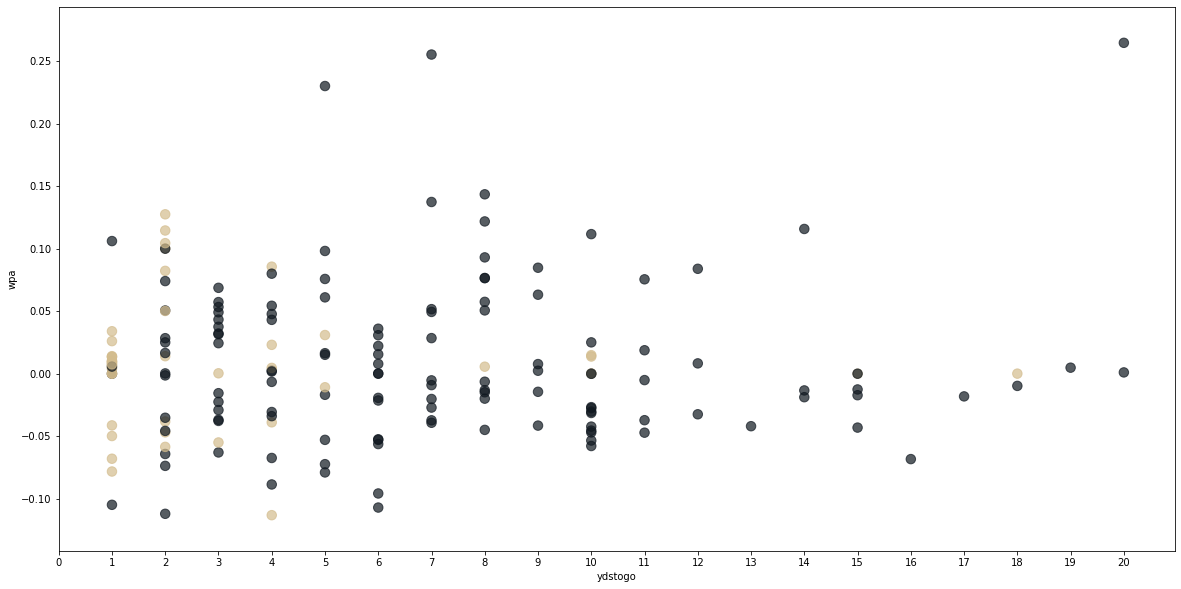

In [30]:
# run = gold, pass = black
cols = eda1["play_type"].map({"run": "#D3BC8D", "pass": "#101820"})
eda1.plot.scatter(x="ydstogo", 
                  y="wpa", 
                  c=cols, alpha=0.7, s = 90, 
                  figsize=(20,10), 
                  xticks=range(eda1.ydstogo.max()+1))

**Insight**: The Saints primarily ran the ball on third-down when it was 2 yards or less to go. On 3rd and 1, the run plays added to the win probability about as many times as it detracted. However on 3rd and 2, there were decidedly more positive results. After 3rd and 5, the Saints generally passed the ball. Only a few runs over this distance added to the win probability.

### Investigating Getting the First Down by Play Type

In [31]:
# Get play choice
eda2_playtype = NO_qual_des_play[["play_id", "play_type"]]

# Get the successful conversions
eda2_success = (NO_quant_val_play.ydstogo < NO_quant_val_play.yards_gained)

# Crosstab
pd.crosstab(eda2_success, eda2_playtype.play_type)

play_type,pass,run
row_0,,
False,86,28
True,46,19


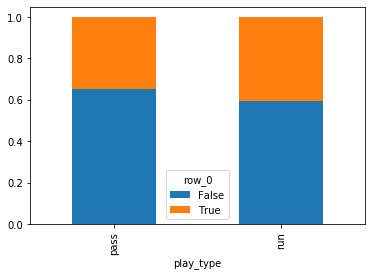

In [32]:
# Plot Conditional Prob.
success_choice_counts = pd.crosstab(eda2_success, eda2_playtype.play_type)
choice_counts = success_choice_counts.sum(axis=0)
success_given_choice = success_choice_counts.divide(choice_counts, axis=1).T
success_given_choice
success_given_choice.plot.bar(stacked=True)

**Insight**: The conditional probability of converting the third down on a run play was slightly higher than that of a pass. However, given that these plays are generally run with shorter yardage to go, one would expect a much larger difference.

### Investigating Who Should Get the Ball on Third Down

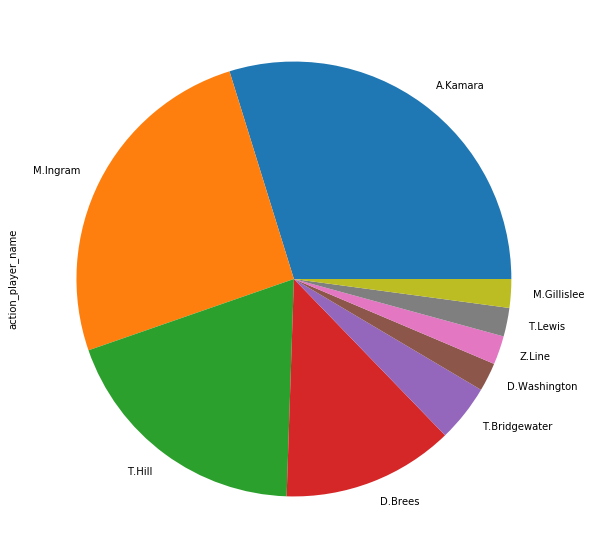

In [33]:
eda3_runs = NO_qual_des_play[NO_qual_des_play["play_type"] == 'run']

eda3_counts = eda3_runs.action_player_name.value_counts()

eda3_counts.plot.pie(figsize=(10,10))

**Insight**: The Saints most frequently ran with Mark Ingram, Alvin Kamara, and Taysom Hill.

In [34]:
eda3_stats = quant_val_player_rush[(quant_val_player_rush.Player.isin(["A.Kamara", "M.Ingram", "T.Hill"])) & 
                                   (quant_val_player_rush.Tm == "NOR")]

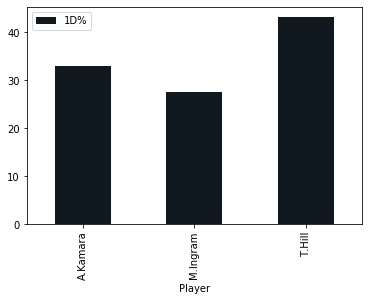

In [35]:
eda3_stats.plot.bar(x="Player", y="1D%", color ="#101820")

**Insight**: Out of the three most frequent rushers, Taysom Hill had the best 1D%. Perhaps this was a component of Taysom Hill's large contract extension signed before the 2020 season.

In [36]:
eda3_rundata = eda3_runs[["play_id", "action_player_name"]].merge(NO_quant_val_play, on="play_id")

eda3_runssuccess = (eda3_rundata.ydstogo < eda3_rundata.yards_gained)

pd.crosstab(eda3_runssuccess, eda3_rundata.action_player_name)[["A.Kamara", "M.Ingram", "T.Hill"]]

action_player_name,A.Kamara,M.Ingram,T.Hill
row_0,,,
False,7,10,6
True,7,2,3


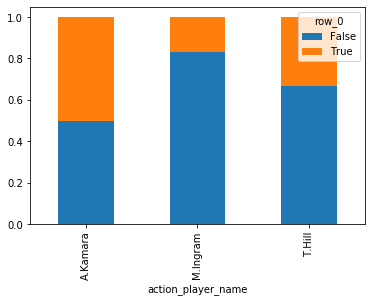

In [37]:
# Plot Conditional Prob.
success_player_counts = pd.crosstab(eda3_runssuccess, eda3_rundata.action_player_name)[["A.Kamara", "M.Ingram", "T.Hill"]]
player_counts = success_player_counts.sum(axis=0)
success_given_player = success_player_counts.divide(player_counts, axis=1).T
success_given_player
success_given_player.plot.bar(stacked=True)

**Insight**: Out of the three most frequent rushers, Alvin Kamara had the best conditional probability of third-downs converted. Perhaps this was a component of Alvin Kamara's large contract extension signed before the 2020 season.

Also, Mark Ingram was let go after the 2019 season. This is likely due to the performance of Kamara and Hill.

### Investigating Whether the Saints Ever "Played for Fourth Down"
"Playing for Fourth Down" is a unique phenomonen brought about by the analytics research done on fourth-down conversions described in the introduction. Teams have begun to run the ball on third and medium, in hopes that they will either convert the third down or get to a fourth down which is more probable to convert than the given third and medium. The following section investigates if the Saints employed this tactic in 2018.

In [38]:
eda4_med = NO_quant_val_play[(NO_quant_val_play.ydstogo > 3) & (NO_quant_val_play.ydstogo < 8)]
NO_qual_des_play[NO_qual_des_play.play_type == "run"].merge(eda4_med, on="play_id", how="inner")

,play_id,game_id,posteam,posteam_type,defteam,side_of_field,game_half,time,play_type,action_player_name,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,ydstogo,yards_gained,epa,wpa,total_home_score,total_away_score
0,11102018100800,2018100800,NO,home,WAS,WAS,Half1,11:12,run,D.Brees,5.0,672.0,672.0,2472.0,4,2,2.630591,0.085540,6,3
1,32332018102101,2018102101,NO,away,BAL,BAL,Half2,07:34,run,T.Hill,21.0,454.0,454.0,454.0,4,3,-0.930255,-0.038993,17,14
2,41802018110409,2018110409,NO,home,LA,LA,Half2,02:36,run,A.Kamara,44.0,156.0,156.0,156.0,4,3,-0.874036,0.004533,45,35
3,15632018112202,2018112202,NO,home,ATL,ATL,Half1,04:05,run,A.Kamara,20.0,245.0,245.0,2045.0,4,8,1.038360,0.022996,10,3
4,39042018121700,2018121700,NO,away,CAR,CAR,Half2,01:51,run,T.Lewis,5.0,111.0,111.0,111.0,4,4,-3.853222,-0.113279,7,12
5,10962018123007,2018123007,NO,home,CAR,CAR,Half1,14:15,run,T.Bridgewater,42.0,855.0,855.0,2655.0,5,9,1.448619,0.030831,0,13
6,22682018123007,2018123007,NO,home,CAR,NO,Half2,12:53,run,T.Bridgewater,57.0,773.0,1673.0,1673.0,5,1,-1.713643,-0.010950,0,23


**Insight**: The Saints very rarely played for a managable fourth down. In fact, upon inspection, there were only 4 real cases in which a non-dropback QB ran the ball as such in 2018. Three of the four of these occured during the end of the game, when the Saints were likely trying to run the clock out. All four of them resulted in a managable fourth down or first down.

## Machine Learning
We will now work towards answering the final research question by implementing Logistic Regression to predict the probability of converting the first down. Then, we will use the model to simulate a use case.

In order to do this, I will create two logistic regression models, one for runs and one for passes. When analyzing the use case, I will run the features on both the models and compare the probabilities. The one with the higher probability will be selected.

### Building Passing Features

In [39]:
NO_pass = NO_qual_des_play[NO_qual_des_play.play_type == "pass"]

pass_feat = pd.DataFrame()

#### Qualitative Play Descriptors

I will include the following qualitative play descriptors in the features:
- play_id: will be included for merging purposes and dropped before training the model
- posteam_type: inlcuded for feature engineering, will be dropped
- Action Player Name: The name of the player executing the play, used for merging purposes and will be dropped

In [40]:
# play_id
pass_feat["play_id"] = NO_pass.play_id

# posteam_type
pass_feat["posteam_type"] = NO_pass.posteam_type

# action_player_name
pass_feat["action_player_name"] = NO_pass.action_player_name

#### Quantitative Action Player Values

Because the Saints only used two quarterbacks, and the majority of the time the quarterback was Drew Brees, we only include one feature from the values to signify which quarterback is in the game.

In [41]:
pass_feat = pass_feat.merge(quant_val_player_pass[["Player", "Cmp%"]], 
                            left_on="action_player_name", right_on="Player",
                            how="inner").drop(columns="Player")

#### Quantiative Play Values

I will include the following quantitative play values in the features:
- ydstogo: the yards left to attain a first down or touchdown
- point_dif: the difference in points

In [42]:
pass_feat = pass_feat.merge(NO_quant_val_play[["play_id", "yardline_100", "game_seconds_remaining", "ydstogo", "total_home_score", "total_away_score"]],
                            on = "play_id")

# calculate point differentials
point_dif_list = []
for i in range(len(pass_feat)):
    if pass_feat.iloc[i].posteam_type == "home":
        point_dif_list.append(pass_feat.iloc[i].total_home_score - pass_feat.iloc[i].total_away_score)
    else:
        point_dif_list.append(pass_feat.iloc[i].total_away_score - pass_feat.iloc[i].total_home_score)

# Create column
pass_feat["point_dif"] = point_dif_list

# Drop other columns
pass_feat = pass_feat.drop(columns = ["action_player_name", "game_seconds_remaining", "yardline_100", "play_id", "posteam_type", "total_home_score", "total_away_score"])

In [43]:
pass_feat.head()

,Cmp%,ydstogo,point_dif
0,74.4,2,0
1,74.4,3,0
2,74.4,4,0
3,74.4,1,-7
4,74.4,12,-9


### Building Passing Target
The target is whether or not the third down was converted.

In [44]:
pass_tar = (NO_quant_val_play[NO_quant_val_play.play_id.isin(NO_pass.play_id.to_list())].ydstogo 
            <= 
            NO_quant_val_play[NO_quant_val_play.play_id.isin(NO_pass.play_id.to_list())].yards_gained).reset_index(drop=True) 

pass_tar

0       True
1      False
2      False
3       True
4      False
       ...  
127    False
128    False
129    False
130     True
131     True
Length: 132, dtype: bool

### Splitting Passing into Training and Testing

In [45]:
# Training Features
pass_train_feat = pass_feat.sample(frac=.7, random_state = 4)
pass_train_feat.head()

,Cmp%,ydstogo,point_dif
5,74.4,8,-9
35,74.4,7,9
83,74.4,3,14
100,74.4,2,-3
19,74.4,8,0


In [46]:
# Training Target
pass_train_tar = pass_tar.sample(frac=.7, random_state = 4)
pass_train_tar.head()

5      False
35      True
83     False
100     True
19     False
dtype: bool

In [47]:
# Testing Features
pass_test_feat = pass_feat.drop(pass_train_feat.index)
pass_test_feat.head()

,Cmp%,ydstogo,point_dif
0,74.4,2,0
3,74.4,1,-7
8,74.4,12,-3
9,74.4,5,0
21,74.4,10,3


In [48]:
# Testing Target
pass_test_tar = pass_tar.drop(pass_train_tar.index)
pass_test_tar.head()

0      True
3      True
8     False
9      True
21    False
dtype: bool

### Fitting Logistic Regression Model
We will use [Logistic Regression with Cross-Validation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to build our model

In [49]:
# Build Pipeline -- Vectorize, Scale, LR
pass_vec = DictVectorizer(sparse=False)
pass_scaler = StandardScaler()
pass_model = LogisticRegressionCV(Cs=3, solver = 'newton-cg', cv=5)
pass_pipe = Pipeline([("vectorizer", pass_vec), ("scaler", pass_scaler), ("fit", pass_model)])

In [50]:
# Fit Pipeline to Training
pass_train_feat_dict = pass_train_feat.to_dict(orient="records")
pass_pipe.fit(pass_train_feat_dict, pass_train_tar)

Pipeline(memory=None,
         steps=[('vectorizer',
                 DictVectorizer(dtype=<class 'numpy.float64'>, separator='=',
                                sort=True, sparse=False)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('fit',
                 LogisticRegressionCV(Cs=3, class_weight=None, cv=5, dual=False,
                                      fit_intercept=True, intercept_scaling=1.0,
                                      l1_ratios=None, max_iter=100,
                                      multi_class='warn', n_jobs=None,
                                      penalty='l2', random_state=None,
                                      refit=True, scoring=None,
                                      solver='newton-cg', tol=0.0001,
                                      verbose=0))],
         verbose=False)

In [51]:
# Analyze weights
weight_df = pd.DataFrame({"feature": pass_train_feat.columns, "weight": pass_model.coef_.flatten()})
weight_df

,feature,weight
0,Cmp%,-0.137625
1,ydstogo,0.458926
2,point_dif,-0.538433


After substantial feature engineering, we were able to isolate three features which best represent the data. The Cmp% has no intuitive meaning other than to signify whether Drew Brees or Teddy Bridgewater is in the game. 

In [52]:
pass_test_feat_dict = pass_test_feat.to_dict(orient="records")
pass_pipe.score(pass_test_feat_dict, pass_test_tar)

0.75

We were able to achieve an accuracy score of 75%.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdc7cd7e310>)

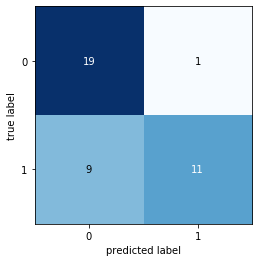

In [53]:
plot_confusion_matrix(confusion_matrix(pass_test_tar, pass_pipe.predict(pass_test_feat_dict)))

The model nearly eliminates false positives, but has some propensity for false negatives. This is okay because it means the model is relatively conservative.

### Building Running Features

In [54]:
NO_run = NO_qual_des_play[NO_qual_des_play.play_type == "run"]

run_feat = pd.DataFrame()

#### Qualitative Play Descriptors
We can use the same Qualitative Play Descriptors as in the Passing Features

In [55]:
# play_id
run_feat["play_id"] = NO_run.play_id

# posteam_type
run_feat["posteam_type"] = NO_run.posteam_type

# action_player_name
run_feat["action_player_name"] = NO_run.action_player_name

#### Quantitative Action Player Values

Because the Saints use a stable of running backs, there are more intuitive features to describe the player running the ball. The two features that led to the highest accuracy were Y/A and Fum%.

In [56]:
run_feat = run_feat.merge(quant_val_player_rush[quant_val_player_rush.Tm == "NOR"], 
                            left_on="action_player_name", right_on="Player",
                            how="inner").drop(columns="Player")

#### Quantiative Play Values

Much like the passing data, ydstogo was important to the regression.

In [57]:
run_feat = run_feat.merge(NO_quant_val_play[["play_id", "yardline_100", "game_seconds_remaining", "ydstogo", "total_home_score", "total_away_score"]],
                            on = "play_id")

# calculate point differentials
point_dif_list = []
for i in range(len(run_feat)):
    if run_feat.iloc[i].posteam_type == "home":
        point_dif_list.append(run_feat.iloc[i].total_home_score - run_feat.iloc[i].total_away_score)
    else:
        point_dif_list.append(run_feat.iloc[i].total_away_score - run_feat.iloc[i].total_home_score)

# Create column
run_feat["point_dif"] = point_dif_list

# Drop other columns
run_feat = run_feat.drop(columns = ["Tm", "yardline_100", "TD%", "1D%", "point_dif", "action_player_name", "game_seconds_remaining", "play_id", "posteam_type", "total_home_score", "total_away_score"])


### Building Running Target
The target is whether or not the third down was converted.

In [58]:
run_tar = (NO_quant_val_play[NO_quant_val_play.play_id.isin(NO_run.play_id.to_list())].ydstogo 
            <= 
            NO_quant_val_play[NO_quant_val_play.play_id.isin(NO_run.play_id.to_list())].yards_gained).reset_index(drop=True) 

run_tar.head()

0     True
1     True
2     True
3    False
4     True
dtype: bool

### Splitting Running into Training and Testing

In [59]:
# Training Feat
run_train_feat = run_feat.sample(frac=.6, random_state=254)
run_train_feat.head()

,Y/A,Fum%,ydstogo
16,5.3,2.7,2
19,5.3,2.7,4
1,4.6,0.5,1
22,5.3,2.7,2
30,4.7,2.2,1


In [60]:
# Training Target
run_train_tar = run_tar.sample(frac=.6, random_state=254)
run_train_tar.head()

16     True
19    False
1      True
22    False
30    False
dtype: bool

In [61]:
# Testing Features
run_test_feat = run_feat.drop(run_train_feat.index)
run_test_feat.head()

,Y/A,Fum%,ydstogo
3,4.6,0.5,2
6,4.6,0.5,15
7,4.6,0.5,2
10,4.6,0.5,1
14,2.7,6.2,1


In [62]:
# Testing Target
run_test_tar = run_tar.drop(run_train_tar.index)
run_test_tar.head()

3     False
6     False
7      True
10    False
14     True
dtype: bool

### Fitting Logistic Regression Model

In [63]:
# Build Pipeline -- Vectorize, Scale, LR
run_vec = DictVectorizer(sparse=False)
run_scaler = StandardScaler()
run_model = LogisticRegressionCV(Cs=5, solver = 'liblinear', cv=3)
run_pipe = Pipeline([("vectorizer", run_vec), ("scaler", run_scaler), ("fit", run_model)])

In [64]:
# Fit Model to Training Data
run_train_feat_dict = run_train_feat.to_dict(orient="records")
run_pipe.fit(run_train_feat_dict, run_train_tar)

Pipeline(memory=None,
         steps=[('vectorizer',
                 DictVectorizer(dtype=<class 'numpy.float64'>, separator='=',
                                sort=True, sparse=False)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('fit',
                 LogisticRegressionCV(Cs=5, class_weight=None, cv=3, dual=False,
                                      fit_intercept=True, intercept_scaling=1.0,
                                      l1_ratios=None, max_iter=100,
                                      multi_class='warn', n_jobs=None,
                                      penalty='l2', random_state=None,
                                      refit=True, scoring=None,
                                      solver='liblinear', tol=0.0001,
                                      verbose=0))],
         verbose=False)

In [65]:
# Analyze Weights
weight_df = pd.DataFrame({"feature": run_train_feat.columns, "weight": run_model.coef_.flatten()})
weight_df

,feature,weight
0,Y/A,0.122328
1,Fum%,-0.144007
2,ydstogo,-0.789775


As was expected, ydstogo is heavily negatively weighted.

In [66]:
run_test_feat_dict = run_test_feat.to_dict(orient="records")
run_pipe.score(run_test_feat_dict, run_test_tar)

0.5789473684210527

The accuracy is lower than the passing data. This is due to the small sample size of third-down runs from 2018.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdc7cd67610>)

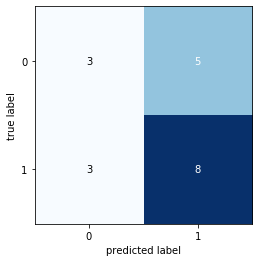

In [67]:
plot_confusion_matrix(confusion_matrix(run_test_tar, run_pipe.predict(run_test_feat_dict)))

The model is more aggressive, which must be considered in decision making.

## Decision-Making

The models can be used to predict the chance of converting a third down. We will outline a test case below.

### Choosing a Play during the First Game of 2019

Consider the following situation. The New Orleans Saints are playing their first game in 2019. They have brought back their entire offensive line from the prior year, as well as Drew Brees, Alvin Kamara, and Taysom Hill. Because, it is the first game of the season, the only data they have is from 2018

In [68]:
# initalize df
case_player_feat = pd.DataFrame()

# add players
case_player_feat["Player"] = ["D.Brees", "T.Hill", "A.Kamara"]

# add passing data
case_player_feat = case_player_feat.merge(quant_val_player_pass[quant_val_player_pass["Tm"] == "NOR"].drop(columns="Tm"), 
                                          on="Player", 
                                          how="left").fillna(0.0)

# add rushing data
case_player_feat = case_player_feat.merge(quant_val_player_rush[quant_val_player_rush["Tm"] == "NOR"].drop(columns="Tm"),
                                          on="Player",
                                          suffixes=("_pass", "_run"))
case_player_feat
                                          

,Player,Cmp%,TD%_pass,Int%,1D%_pass,Sk%,Y/A_pass,Y/A_run,1D%_run,TD%_run,Fum%
0,D.Brees,74.4,6.5,1.0,45.6,3.4,8.2,0.7,38.7,12.9,16.1
1,T.Hill,42.9,0.0,14.3,42.9,12.5,9.1,5.3,43.2,5.4,2.7
2,A.Kamara,0.0,0.0,0.0,0.0,0.0,0.0,4.6,33.0,7.2,0.5


It is the first quarter, and they are down 3. The situation is 3rd and 4. Coach Sean Payton asks whether he should run or pass and who should be on the field. As a result, they run the passing model for Brees (the primary passer) and the rushing model for Kamara and Hill (the primary rushers).

#### Passing Model

In [69]:
case_pass_feat = case_player_feat[["Cmp%"]].iloc[0] 
case_pass_feat["ydstogo"] = 4
case_pass_feat["point_dif"] = 3
case_pass_feat

Cmp%         74.4
ydstogo       4.0
point_dif     3.0
Name: 0, dtype: float64

In [70]:
case_pass_feat_dict = case_pass_feat.to_dict()
pass_pipe.predict_proba(case_pass_feat_dict)[0][1]

0.49643379318452313

**Option 1**: They have just under a 50/50 shot of getting the first if they throw the ball.

#### Running Model

In [71]:
case_run_feat = case_player_feat[["Y/A_run", "Fum%"]][1:]
case_run_feat["ydstogo"] = 4
case_run_feat

,Y/A_run,Fum%,ydstogo
1,5.3,2.7,4
2,4.6,0.5,4


In [72]:
case_run_feat_dict = case_run_feat.to_dict(orient="record")
run_pipe.predict_proba(case_run_feat_dict)[:,1].reshape((2,1))

array([[0.53492188],
       [0.51753085]])

**Option 2**: Regardless of who runs, they have a better shot of getting the first. Taysom Hill has a slightly better chance to get the first.

#### Deciding Which Play to Run

The models suggest that Taysom Hill should run the ball for this particular situation.

## Limitations
The analysis above has two primary limitations:

- Personnel: Because a team really only has one QB and one or two running backs, strange behavior occurs when modeling player statistics. However, because the player features increased the accuracy, they were included in the models.

- Size: There are relatively few third-downs in a season. As a result, there are even less runs. The model is definitely overfit for 2018, as well as overfit for the individual runs.

In terms of play selection, there is not a solution for the first limitation. However, if a similar tool was expanded to the entire league of players, the model could be improved upon and used for to evaluate acquistions.

The second solution could be expanded upon by adding in past data. However, this also causes problems because key skill players and, more importantly (and harder to adjust for), lineman could be missing. As a result, we refrained from using past data in this tutorial.

## Summary

The following analyses were discussed in the tutorial.
- The Saints' tend to run the ball on 3rd and less than 5. 
- The Saints convert runs at a slightly higher rate than they convert passes.
- Taysom Hill and Alvin Kamara were dynamic on third-down run plays, while Mark Ingram lagged behind.
- The Saints very rarely play for a manageable fourth-down, and when they do, it is likely when they are trying to run the clock out.
- Using Logistic Regression to model passes is more accurate than Logistic Regression for runs, likely due to the lack of third-down rushing data.
- When using the Logistic Regression models to decide which play and personnel to use on 3rd and 4, the model suggests running the ball with Taysom Hill.